# Bayesian A/B Testing 

# Objectives

1. Identify the drawbacks of t-tests in A/B testing (*theory*)
2. Introduce the Bayesian approach for A/B testing (*theory*)
3. Introduce the PyMC3 package (*programming tool for coding in python*) 
4. Apply the Bayesian approach on a advertisement CTR A/B test using daily CTR data (*application: in-class code-along*)
5. Apply the Bayesian approach on a advertisement CTR A/B test using user data (*application: lab-exercise; separate notebook*)

# Warm-up

### In groups of 2 - 3, research and attempt answering the following questions:   (*time: 15 mins*)

1. What is A/B testing ? Name 3-5 use cases (*recap question*)

2. What is a t-test ? How is it used in the context of A/B testing ? what does the p-value represent ? (*recap question*)

3. Name and explain 1-2 drawbacks of t-tests

## A:

**1. What is A/B testing ? Name 3-5 use cases**

Empirically deciding the best of two or more “treatments” w.r.t a quantity of interest


Example use cases:
- clinical trials (which treatment has better efficacy)
- advertising and web design (which version has a better conversion rate ?)
- online machine learning (which model performs better in production ?)


**2. What is a t-test ? How is it used in the context of A/B testing ?**



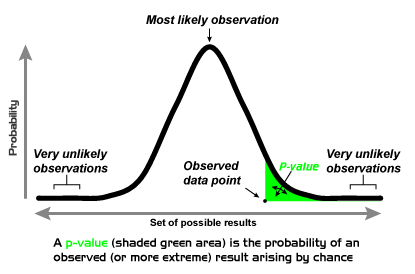



[source; Creative Commons licensed](https://data-flair.training/blogs/python-statistics/)

How t-test are used in the context of A/B testing:

- transform the problem → H0, H1
- choose ⍺→ 95%, 99%
- calculate test statistic Z → p-value 
- reject or Do Not eject H0


p-value = max. allowed prob. of false alarm = prob. of the observed data assuming H0 is true → *P(Data|Null Hypothesis)*


## 1. Identify the drawbacks of t-tests in A/B testing

### 1.1 Assumptions of t-test are often invalid

**some of the most commonly violated t-test assumptions by real-world data:**
 
- sampled data is normally distributed (tailed data violates this assumption)
- same distribution sampling (CTR can be different during weekends and weekdays)
- no significant outliers
- independence of observations (often violated in the e-commerce data; users can visit multiple times and converge once)

### 1.2 False positives - p-hacking - Type I error

**Type I error** ==> our p-value

- value chosen arbitrary (90%? 95%? 99%)
- yes/no question
- no-peeking!

### 1.3 Choosing sample size - Test Power - Type II error 

- t-tests sample size: [sample size calculator](https://www.stat.ubc.ca/~rollin/stats/ssize/n2.html)
- the higher the test power, the smaller the actual difference in means, the more data we need to collect


### 1.4 Unintuitive approach that does not use prior beliefs



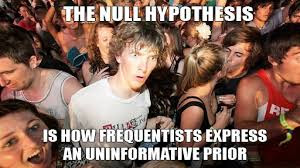

[source](https://stats.stackexchange.com/questions/57117/bayesian-uninformative-priors-vs-frequentist-null-hypotheses-whats-the-relati)

## 2. Introduction to the Bayesian approach for A/B testing

### 2.1 How does the Bayesian and Frequentist approaches differ ?

**Frequentist** → parameters have “true” values →  data is random → interested in estimating parameters (e.g. MLE)



**Bayesian** → parameters are RVs → data once observed is fixed →  interested in finding distributions of parameters 

### 2.2 Foundations of the Bayesian approach

**Baye's Rule**


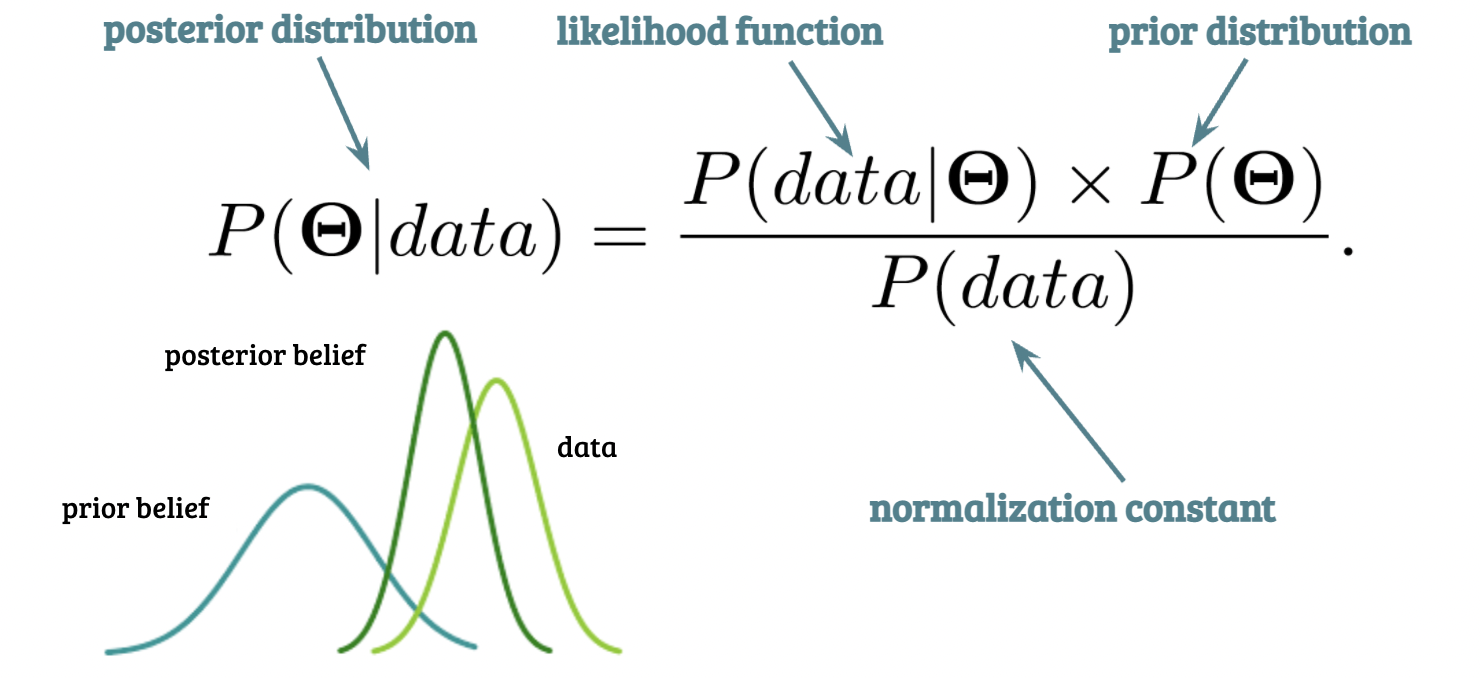

**Steps of the Bayesian approach:**

1. Choose a likelihood distribution for the observed data → how can the data be generated ?


2. Choose priors for all statistical parameters in your likelihood distribution

    * discrete or continuous ?
    * expected range ?
    * prior beliefs or information ?


3. Calculate (Sample!) the posterior distribution


4. Use descriptive statistics of posterior distribution to answer questions at hand


## 3. PyMC3 python package

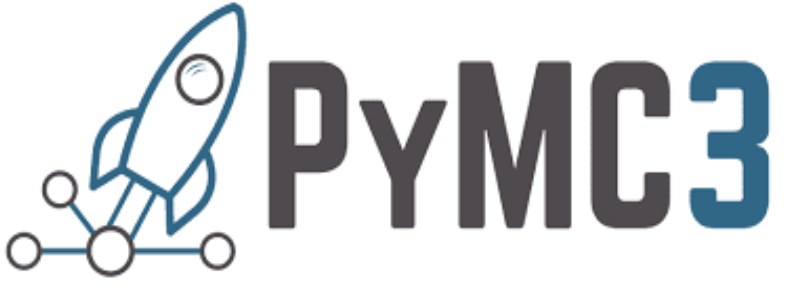
[download instructions and documentation](https://docs.pymc.io/en/stable/)

- Pymc3 is a python library for **Probabilistic Programming**


- allows you to write down models using a **pseudo code** like syntax to describe a data generating process


- uses  **Markov Chain Monte Carlo sampling (MCMC)** methods to fit models, i.e. sample posterior distributions


## 4. Example: advertisement Click Through Rate (CTR) case study

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc3 as pm

### 4.1 Data

We will consider a case where we are interested in running an A/B test for determining the best of two possible ads  designs, ads A and B, running on the same marketing channel based on their Click Through Rate (CTR), wich is simply the number of clicks the ad gets out of the total number of impressions (views).

In that example, the CTR is in fact the true probability of each ad version being clicked, which is of course a value between 0 and 1. We will assume we have no prior knowledge of CTR_A and CTR_B. 

We will assume that we already ran the experiment and collected the data. We will synthesize this data here ourselves as follows:


In [2]:
# set constants
# remember, we do not know these values. 
# CTR values are normally less than 5%
CTR_A_true = 3.0 
CTR_B_true = 3.5 # Let's make CTR_B 15% better

# Number of samples in the test. 
# We assume for now it is the same value for each group. We will see how we can change this assumption later.
N_A = N_B  = 30 # days if we are observing daily CTR

# we will use a normal RV here (mean = CTR and std = 1).
# We will also assume an equal spread in the data in both groups
data_A = stats.norm.rvs(loc = CTR_A_true, scale=1, size=N_A)
data_B = stats.norm.rvs(loc = CTR_B_true, scale=1, size=N_B)

print("observed CTR_A = ", np.mean(data_A))
print("observed CTR_B = ", np.mean(data_B))


observed CTR_A =  3.289972894622475
observed CTR_B =  3.2596738071511075


### 4.2 Frequentist A/B testing using T-tests

In [3]:
# let's apply the independent two sided T-test from scipy
# Assume a 95% significance value, i.e. if p-value > 0.05 we can not reject the null hypothesis that CTR_A = CTR_B
test_statistic, pvalue = stats.ttest_ind(data_A, data_B)

print (test_statistic, pvalue)

0.1167501250414173 0.9074614006612276


### How does the pvalue change with N ? 

In [4]:
*N, = range(10, 200)
p_values = []

for n in N:
    data_A_ = stats.norm.rvs(loc = CTR_A_true, scale=1, size=n)
    data_B_ = stats.norm.rvs(loc = CTR_B_true, scale=1, size=n)
    
    t_statistic, pvalue = stats.ttest_ind(data_A_, data_B_)
    
    p_values.append(pvalue)

(0.0, 1.0)

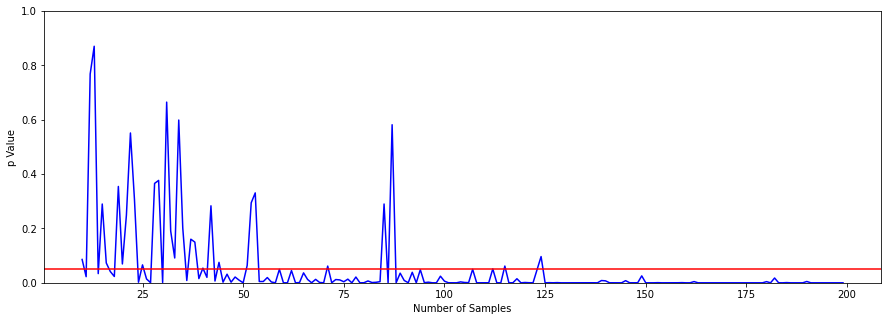

In [5]:
figsize(15, 5)
plt.plot(N, p_values, color="b")
plt.xlabel("Number of Samples")
plt.ylabel("p Value")
plt.axhline(0.05, color="r")
plt.ylim([0.0, 1.0])

### Conclusion:

1. The smaller the effect we are trying to measure, the more sample we have to have and hence the longer we have to run the A/B test. This is sometimes not feasible.

2. We still have a 5% error rate even if we have enough samples.

3. If we fail to reject H0, that does not tell us whether A is better than B or not, we just do not have enough evidence!

4. The t-test assumes that we are sampling randomly from two distinct populations/distributions. This assumption often
   does NOT apply. Example: Black Friday CTR are expected to be higher than other days.

5. To apply the t-test, both groups must have equal number of samples
   

### 4.3 Bayesian A/B test approaches using PyMC3 - Estimating the CTR from daily CTR data

#### Step 1: Choose a likelihood distribution for the observed data → how can the data be generated ?

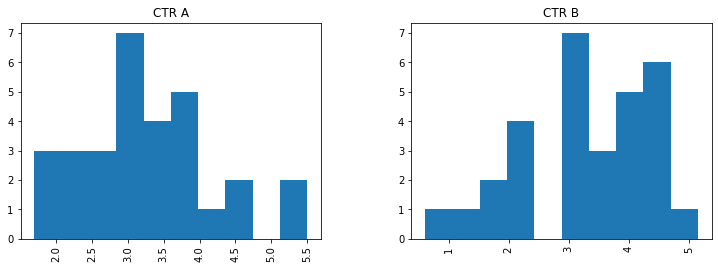

In [6]:
pooled_data = pd.DataFrame(
    dict(value=np.r_[data_A, data_B], group=np.r_[["CTR A"] * len(data_A), ["CTR B"] * len(data_B)])
)

pooled_data.hist("value", by="group", figsize=(12, 4));

- since the data here is continous and has a somewhat uniform shape, we can go with a t-distribution liklihood
- t-distributions are more robust to outliers 
- t-distributions are defined by three parameters:  
    1. mean 𝜇
    2. precision (inverse-std) 𝜆
    3. degrees-of-freedom parameter 𝜈
- the degrees-of-freedom parameter essentially specifies the “normality” of the data 
- larger values of 𝜈 make the distribution converge to a normal distribution

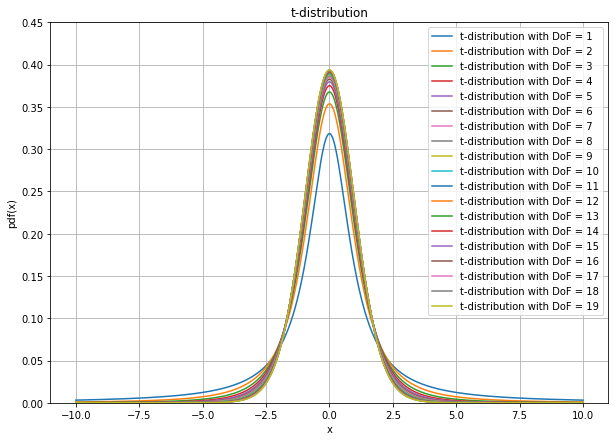

In [7]:


fig, ax = plt.subplots(figsize=(10,7))
*dof, = np.arange(1,20)
xs = np.linspace(-10,10,1000)

# note here that in scipy the scale parameter is the std not the inverse
for df in dof:
    ax.plot(xs, stats.t.pdf(xs,loc=0, scale=1, df=df), label="t-distribution with DoF = {}".format(df))

ax.set_xlabel('x')
ax.set_ylabel('pdf(x)')
ax.set_title('t-distribution')
ax.legend(loc='best', frameon=True)
ax.set_ylim(0,0.45)
ax.grid(True)

#### Step 2: Choose priors for all statistical parameters in your likelihood distribution

- so for each group, we have three RVs: mean, std and df

- let's assume the two groups/Ads have different means (our CTRs) and spreads (std) but the same df

- the **means** are RVs and a reasonable prior would be a **normal distribution** with mean and std equal the pooled empirical corresponding values

- **std** is also a RV here. We dont know much about the true spread of both groups so we will use a **uniform** prior the limits of the uniform distribution can be guessed based on our knowledge of possible realistic values for CTR

- for the **degree of freedom (df)**, there is a higher probability that the data distribution is closer to a **normal** than a t-distribution with fat tails. Hence we use an exponential prior


In [8]:


pooled_mean = pooled_data.value.mean()
pooled_std = pooled_data.value.std() * 2

with pm.Model() as model:
    mean_A = pm.Normal("mean_A", mu=pooled_mean, sd=pooled_std)
    mean_B = pm.Normal("mean_B", mu=pooled_mean, sd=pooled_std)

In [9]:


std_low = 1
std_high = 5

with model:
    std_A = pm.Uniform("std_A", lower=std_low, upper=std_high)
    std_B = pm.Uniform("std_B", lower=std_low, upper=std_high)

In [10]:
with model:
    df = pm.Exponential("df_minus_one", 1 / 29.0) + 1

#### step 3: sample the posterior distribution

In [11]:
# defining our liklihood 

precision_A = std_A ** -2
precision_B = std_B ** -2

with model:
    liklihood_A = pm.StudentT("liklihood_A", nu=df, mu=mean_A, lam=precision_A, observed=data_A)
    liklihood_B = pm.StudentT("liklihood_B", nu=df, mu=mean_B, lam=precision_B, observed=data_B)
    delta_of_means = pm.Deterministic("delta_of_means", mean_B - mean_A)
    
    # sampling the posterior distributions
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step, return_inferencedata=False)
    usable_trace=trace[1000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [df_minus_one]
>Metropolis: [std_B]
>Metropolis: [std_A]
>Metropolis: [mean_B]
>Metropolis: [mean_A]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 25 seconds.
The number of effective samples is smaller than 25% for some parameters.


#### step 4: Use descriptive statistics of posterior distribution to answer questions at hand - Which Ad has a better CTR ? By how much ?

In [12]:
mean_A_samples = usable_trace["mean_A"]
mean_B_samples = usable_trace["mean_B"]
delta_of_means_samples = usable_trace["delta_of_means"]

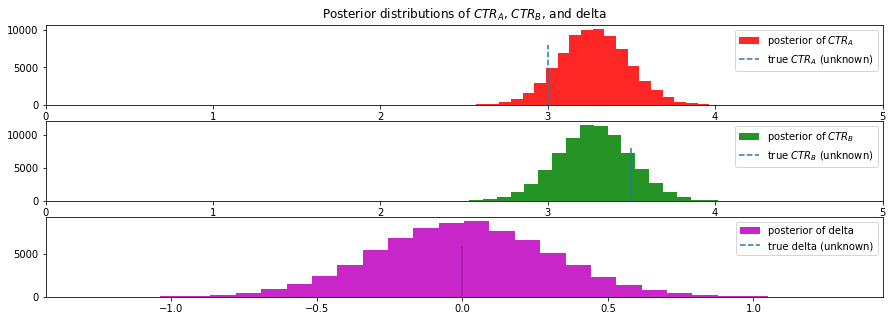

In [13]:

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, 5)
plt.hist(mean_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $CTR_A$", color="r")
plt.vlines(CTR_A_true, 0, 8000, linestyle="--", label="true $CTR_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $CTR_A$, $CTR_B$, and delta")

ax = plt.subplot(312)

plt.xlim(0, 5)
plt.hist(mean_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $CTR_B$", color="g")
plt.vlines(CTR_B_true, 0, 8000, linestyle="--", label="true $CTR_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_of_means_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="m")
plt.vlines(CTR_B_true - CTR_A_true, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 6000,  color="black", alpha=0.2)
plt.legend(loc="upper right");

In [14]:

print("Probability Ad B is WORSE than Ad A = {}".format(np.mean(delta_of_means_samples < 0)))
    

print("Probability Ad B is BETTER than Ad A = {}".format(np.mean(delta_of_means_samples > 0)))
    

print("Estimated Improvement of CTR of Ad B over Ad A = {}".format(np.mean(delta_of_means_samples)))

Probability Ad B is WORSE than Ad A = 0.49955263157894736
Probability Ad B is BETTER than Ad A = 0.5004473684210526
Estimated Improvement of CTR of Ad B over Ad A = -0.0008289736395551603


### Conclusion:

1. I was able to interpret uncertainty in answering my question: is ad A better than ad B ?
2. I was able to estimate the difference between the CTR performance of both versions
3. Having the posterior distribution can also be used in calculating variance, confidence intervals ..etc.

### Resources and additional topics in Bayesian Statistics to explore 

1. [Probabilistic Programming and Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)


2. [Bayesian Analysis with Python](https://www.packtpub.com/product/bayesian-analysis-with-python-second-edition/9781789341652) 


3. [PyMC3 Documentation](https://docs.pymc.io/)


4. Bayesian Machine Learning → example: [Bayesian linear regression](https://docs.pymc.io/notebooks/GLM-linear.html)


4. [Conjugate Priors](https://en.wikipedia.org/wiki/Conjugate_prior)
